In [8]:
import os
import sys
import warnings
import logging
from collections import defaultdict
import signal
import atexit


# Typing
from typing import List, Dict

# Hydra & config
import hydra
from omegaconf import OmegaConf, DictConfig

# JAX & Equinox
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import wandb
import jax.profiler
import numpy as np

# Foundational SSM core imports
from foundational_ssm.data_utils import get_brainset_train_val_loaders, transform_brainsets_regular_time_series_smoothed, get_dataset_config
from foundational_ssm.models import SSMFoundationalDecoder
from foundational_ssm.constants import DATASET_IDX_TO_GROUP_SHORT, DATA_ROOT
from foundational_ssm.utils.training import get_filter_spec, create_cosine_annealing_scheduler, mse_loss_foundational, make_step_foundational, predict_batch
from foundational_ssm.metrics import compute_r2_standard
from foundational_ssm.utils.wandb_utils_jax import save_checkpoint_wandb, load_checkpoint_wandb, save_best_model_wandb
from foundational_ssm.utils.training_utils import (
    log_batch_metrics, track_batch_timing, 
    setup_wandb_metrics, log_epoch_summary, compute_r2_by_groups,
    prepare_batch_for_training, extract_batch_data
)

import warnings
import traceback
import sys

import multiprocessing as mp

import h5py
import torch
import time
import psutil
import logging

logging.basicConfig(filename='pretrain_decoding.log', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)
WARNING_LOG_FILE = "warnings.log"

# Global variables for signal handling
interrupted = False
current_training_state = None  # Will store (model, state, opt_state, epoch, current_step, run_name)

def signal_handler(signum, frame):
    """Handle interruption signals gracefully"""
    global interrupted
    print(f"[WARNING] Received signal {signum}. Saving checkpoint before exit...")
    interrupted = True

def save_interrupted_checkpoint():
    """Save checkpoint when interrupted"""
    global current_training_state
    if current_training_state is not None:
        model, state, opt_state, epoch, current_step, run_name, metrics = current_training_state
        metadata = {}
        if metrics:
            metadata.update(metrics)
        metadata.update({
            'train_loss': 0.0,  # Will be updated if we have it
            'interrupted': True,
            'interruption_epoch': epoch,
            'interruption_step': current_step
        })
        try:
            save_checkpoint_wandb(model, state, opt_state, epoch, current_step, metadata, run_name)
            print(f"[INFO] Checkpoint saved at epoch {epoch}, step {current_step} due to interruption")
        except Exception as e:
            print(f"[ERROR] Failed to save checkpoint: {e}")

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    with open(WARNING_LOG_FILE, "a") as log:
        traceback.print_stack(file=log)
        log.write(warnings.formatwarning(message, category, filename, lineno, line))

    

# Remove this function since it's now imported from training_utils

def train_one_batch(batch, model, state, filter_spec, loss_fn, opt, opt_state, train_key, lr_scheduler, current_step):
    batch = prepare_batch_for_training(batch)
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    dataset_group_idxs = batch["dataset_group_idx"]
    mask = batch["mask"]
    
    key, subkey = jr.split(train_key)
    model, state, opt_state, loss_value, grads = make_step_foundational(
        model, state, filter_spec, inputs, targets, mask,
        loss_fn, opt, opt_state, subkey, dataset_group_idxs,
    )
    
    current_lr = lr_scheduler(current_step)
    wandb.log({
        "train/loss": loss_value,
        "train/learning_rate": current_lr,
    }, step=current_step)
    return model, state, opt_state, loss_value

def train_one_epoch(train_loader, model, state, filter_spec, loss_fn, opt, opt_state, train_key, lr_scheduler, current_step, epoch):    
    epoch_loss = 0
    batch_count = 0
    minute_start_time = time.time()
    prev_time = time.time()
    
    for batch_idx, batch in enumerate(train_loader):
        data_load_time = time.time() - prev_time
        batch_process_start = time.time()
        
        model, state, opt_state, loss_value = train_one_batch(
            batch, model, state, filter_spec, loss_fn, opt, opt_state, train_key, lr_scheduler, current_step
        )
        batch_process_end = time.time()
        batch_process_time = batch_process_end - batch_process_start
        
        log_batch_metrics(data_load_time, batch_process_time, epoch, current_step)
        epoch_loss += loss_value
        batch_count += 1
        current_time = time.time()
        batch_count, minute_start_time = track_batch_timing(batch_count, minute_start_time, current_time, current_step)
        prev_time = time.time()
        current_step += 1
    
    wandb.log({"train/epoch_loss": epoch_loss, "epoch": epoch}, step=current_step)
    return model, state, opt_state, current_step, epoch_loss
    


def validate_one_epoch(val_loader, model, state, val_key, DATASET_IDX_TO_GROUP_SHORT, compute_r2_standard, epoch, current_step):
    print("[INFO] Validating one epoch")
    metrics = {}  # New: store metrics per group
    all_preds = []
    all_targets = []
    all_dataset_group_idxs = []
    val_start_time = time.time()
    prev_time = time.time()
    for batch_idx, batch in enumerate(val_loader):
        data_load_time = time.time() - prev_time
        batch_process_start = time.time()
        batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
        dataset_group_idxs = batch["dataset_group_idx"]
        inputs = batch["neural_input"]
        targets = batch["behavior_input"]
        mask = batch["mask"]
        mask = mask[..., None]

        key, subkey = jr.split(val_key)
        batch_keys = jr.split(subkey, inputs.shape[0])
        preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, 0, 0), out_axes=(0, None))(inputs, state, batch_keys, dataset_group_idxs)

        all_preds.append(jnp.where(mask, preds, 0))
        all_targets.append(jnp.where(mask, targets, 0))
        all_dataset_group_idxs.append(dataset_group_idxs)
        batch_process_end = time.time()
        batch_process_time = batch_process_end - batch_process_start
        print(f"Batch size: {inputs.shape[0]}, Batch time dimension: {inputs.shape[1]}, Batch {batch_idx} data load time: {data_load_time:.2f}s, batch process time: {batch_process_time:.2f}s")
        prev_time = time.time()


    all_preds = jnp.concatenate(all_preds, axis=0)
    all_targets = jnp.concatenate(all_targets, axis=0)
    all_dataset_group_idxs = jnp.concatenate(all_dataset_group_idxs, axis=0)
    unique_dataset_group_idxs = jnp.unique(all_dataset_group_idxs)
    for dataset_group_idx in unique_dataset_group_idxs:
        dataset_group_idx = int(dataset_group_idx)
        dataset_group_short_name = DATASET_IDX_TO_GROUP_SHORT[dataset_group_idx]
        dataset_group_mask = all_dataset_group_idxs == dataset_group_idx
        preds = all_preds[dataset_group_mask]
        targets = all_targets[dataset_group_mask]
        r2_score = compute_r2_standard(preds, targets)
        metrics[f"val/r2_{dataset_group_short_name}"] = float(r2_score)
    
    r2_score = compute_r2_standard(all_preds, all_targets)
    metrics['val/r2_avg'] = float(np.mean([metrics[key] for key in metrics.keys() if "r2" in key]))
    metrics['val/r2_all'] = float(r2_score)

    # Log validation timing and resources
    val_end_time = time.time()
    val_time = val_end_time - val_start_time
    metrics['val/time'] = val_time
    metrics['epoch'] = epoch

    wandb.log(metrics, step=current_step)
    return metrics




In [2]:
mp.set_start_method("spawn", force=True)

config_path = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/test_pretrain.yaml"
cfg = OmegaConf.load(config_path) 

train_dataset, train_loader, val_dataset, val_loader = get_brainset_train_val_loaders(
    train_config=cfg.train_dataset_config,
    val_config=cfg.val_dataset_config,
    **cfg.dataloader,
    root="../"+DATA_ROOT
)

key, train_key, val_key = jr.split(jr.PRNGKey(cfg.rng_seed), 3)

model = SSMFoundationalDecoder(
        **cfg.model
    )
state = eqx.nn.State(model)

filter_spec = get_filter_spec(
    model,
    **cfg.filter_spec
)


if cfg.optimizer.use_cosine_scheduler:
    total_steps = len(train_loader) * cfg.training.epochs
    lr_scheduler = create_cosine_annealing_scheduler(
        initial_lr=cfg.optimizer.lr,
        total_steps=total_steps,
        min_lr=getattr(cfg.optimizer, 'min_lr', 0.0),  # Default to 0.0 if not specified
        warmup_steps=getattr(cfg.optimizer, 'warmup_steps', 0)  # Default to 0 if not specified
    )
else:
    lr_scheduler = lambda step: cfg.optimizer.lr

opt = optax.chain(
    optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
)
opt_state = opt.init(eqx.filter(model, filter_spec))

loss_fn = mse_loss_foundational

run_name = f"{cfg.wandb.run_prefix}_l{cfg.model.ssm_num_layers}_d{cfg.model.ssm_dim}"
config_dict = OmegaConf.to_container(cfg, resolve=True)


if cfg.wandb.resume_run_id is not None:
    model, state, opt_state, last_epoch, current_step, checkpoint_metadata = load_checkpoint_wandb(
        path=None,  # path is ignored, wandb is used
        model_template=model,
        state_template=state,
        opt_state_template=opt_state,
        wandb_run_name=run_name,
        wandb_project=cfg.wandb.project,
        wandb_entity=cfg.wandb.entity,
    )
    start_epoch = last_epoch + 1
    # Load best R² score from checkpoint metadata if available
    best_r2_score = checkpoint_metadata.get('best_r2_score', 0.0)
else:
    # Start new wandb run
    setup_wandb_metrics()
    start_epoch = 0

INFO:2025-07-19 01:46:53,674:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
wandb:   1 of 1 files downloaded.  


In [3]:
from tqdm import tqdm 

def generate_predictions_and_activations(model, inputs, state, key, group_idxs):
    key, subkey = jr.split(key)
    batch_keys = jr.split(subkey, inputs.shape[0])
    preds, activations_list, state = jax.vmap(model.call_with_activations, axis_name="batch", in_axes=(0, None, 0, 0), out_axes=(0, 0, None))(inputs, state, batch_keys, group_idxs)
    activations = {f'ssm_block_{i}': activations_list[i] for i in range(len(activations_list))}
    return preds, activations

for batch in tqdm(val_loader):
    batch = prepare_batch_for_training(batch)
    
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    
    mask = batch["mask"]
    mask_expanded = mask[..., None]
    
    dataset_group_idxs = batch["dataset_group_idx"]
    key, subkey = jr.split(key)
    batch_keys = jr.split(subkey, inputs.shape[0])
    preds, activations = generate_predictions_and_activations(model, inputs, state, key, dataset_group_idxs)
    break

  0%|          | 0/904 [00:21<?, ?it/s]


In [9]:
from foundational_ssm.data_utils.samplers import TrialSampler



sampling_intervals = val_dataset.get_sampling_intervals()
val_sampler = TrialSampler(sampling_intervals=sampling_intervals)

batch_info = []
start_time = time.time()
for i, index in tqdm(enumerate(val_sampler)):
    recording_id = index.recording_id
    t0 = time.time()
    recording = val_dataset.get_recording_data(recording_id)
    t1 = time.time()
    sample = recording.slice(index.start, index.end)
    t2 = time.time()
    try:
        transformed_sample = transform_brainsets_regular_time_series_smoothed(sample)
        if len(transformed_sample["behavior_input"].shape) == 1:
            print(transformed_sample["behavior_input"].shape)
        t3 = time.time()
    except Exception as e:
        print(f"Error transforming sample {recording_id} at index {i}: {e}")
        continue
    batch_info.append({
        "dataset": recording_id.split("/")[0],
        "recording_id": recording_id,
        "start": index.start,
        "end": index.end,
        "get_recording_data_time": t1 - t0,
        "slice_time": t2 - t1,
        "transform_time": t3 - t2,
        "neural_input_shape": transformed_sample["neural_input"].shape,
        "behavior_input_shape": transformed_sample["behavior_input"].shape,
        "dataset_group_idx": int(transformed_sample["dataset_group_idx"]),
        "batch_time_dimension": transformed_sample["neural_input"].shape[0]
    })
    start_time = time.time()
    break

0it [00:00, ?it/s]


In [11]:
sample.trials.target_corners

array([[-8.99997711,  0.98088819, -6.99997711, -1.01911187]])

In [ ]:
sample

trial_info = {
    'dataset': sample.dataset.id,
    'session': sample.session.id.split("/")[1],    
}


Data(
brainset=Data(
brainsets_version='0.1.0',
derived_version='1.0.0',
description='This dataset contains electrophysiology and behavioral data from three macaques performing either a center-out task or a continuous random target acquisition task. Neural activity was recorded from chronically-implanted electrode arrays in the primary motor cortex (M1) or dorsal premotor cortex (PMd) of four rhesus macaque monkeys. A subset of sessions includes recordings from both regions simultaneously. The data contains spiking activity—manually spike sorted in three subjects, and threshold crossings in the fourth subject—obtained from up to 192 electrodes per session, cursor position and velocity, and other task related metadata.',
id='perich_miller_population_2018',
origin_version='dandi/000688/draft',
source='https://dandiarchive.org/dandiset/000688',
temporaldata_version='0.1.1',
_absolute_start=0.0,
),
cursor=LazyIrregularTimeSeries(
  timestamps=[302],
  acc=<HDF5 dataset "acc": shape (66321,

In [ ]:
trial_dict = sample.movement_phases.materialize().__dict__.copy()

TypeError: Data.__deepcopy__() missing 1 required positional argument: 'memo'

In [31]:
trial_dict

{'_domain': Interval(
   start=[1],
   end=[1]
 ),
 'hold_period': Interval(
   end=[1],
   start=[1]
 ),
 'invalid': Interval(
   end=[0],
   start=[0]
 ),
 'random_period': Interval(
   end=[0],
   start=[0]
 ),
 'reach_period': Interval(
   end=[1],
   start=[1]
 ),
 'return_period': Interval(
   end=[1],
   start=[1]
 ),
 '_absolute_start': np.float64(5.084266666666666)}

In [29]:
6.391-3.997

2.394

In [8]:
batch_info_df = pd.DataFrame(batch_info)
batch_info_df["total_time"] = batch_info_df["get_recording_data_time"] + batch_info_df["slice_time"] + batch_info_df["transform_time"]
batch_info_df.groupby("dataset")[["total_time", "get_recording_data_time", "slice_time", "transform_time"]].mean()

,total_time,get_recording_data_time,slice_time,transform_time
dataset,,,,
churchland_shenoy_neural_2012,0.043544,0.001594,0.020753,0.021197
odoherty_sabes_nonhuman_2017,0.029815,0.002139,0.000958,0.026718
pei_pandarinath_nlb_2021,0.017391,0.001239,0.001411,0.014742
perich_miller_population_2018,0.013421,0.001173,0.001590,0.010657


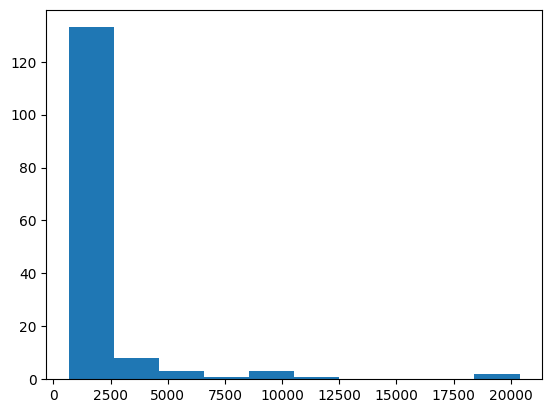

In [11]:
import matplotlib.pyplot as plt
plt.hist(batch_info_df.groupby("recording_id")["batch_time_dimension"].max().sort_values(ascending=False))
plt.show()

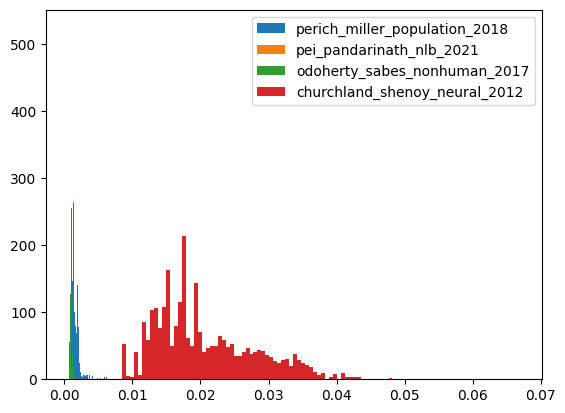

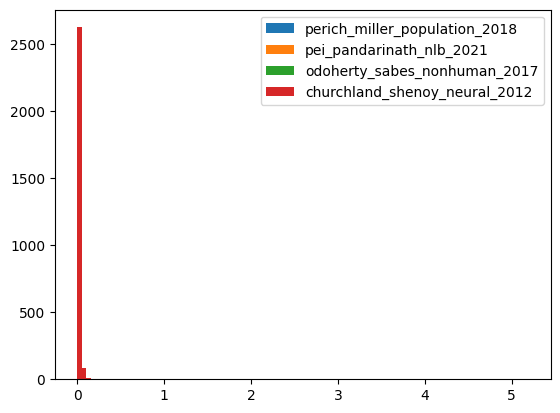

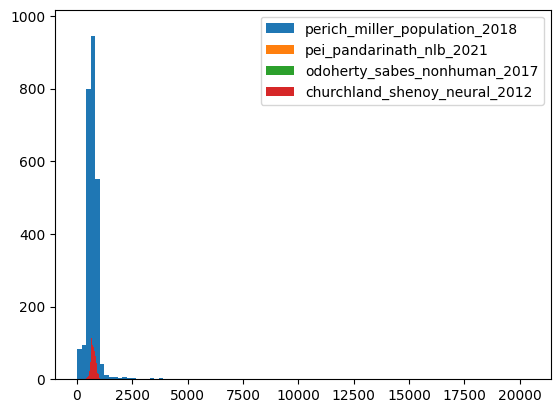

In [12]:
# plot histogram distribution of transform time for each dataset

import pandas as pd
import matplotlib.pyplot as plt

# plot histogram distribution of slice time for each dataset
for dataset in batch_info_df["dataset"].unique():
    dataset_df = batch_info_df[batch_info_df["dataset"] == dataset]
    plt.hist(dataset_df["slice_time"], bins=100, label=dataset)
plt.legend()
plt.show()

# plot histogram distribution of transform time for each dataset
for dataset in batch_info_df["dataset"].unique():
    dataset_df = batch_info_df[batch_info_df["dataset"] == dataset]
    plt.hist(dataset_df["transform_time"], bins=100, label=dataset)
plt.legend()
plt.show()

# plot histogram distribution of transform time for each dataset
for dataset in batch_info_df["dataset"].unique():
    dataset_df = batch_info_df[batch_info_df["dataset"] == dataset]
    plt.hist(dataset_df["batch_time_dimension"], bins=100, label=dataset)
plt.legend()
plt.show()

In [15]:
dataset_df["batch_time_dimension"].quantile(0.99)

np.float64(990.8000000000002)

In [8]:
%load_ext line_profiler
%lprun -f transform_brainsets_regular_time_series_smoothed transform_brainsets_regular_time_series_smoothed(sample)

Timer unit: 1e-09 s

Total time: 0.00240145 s
File: /cs/student/projects1/ml/2024/mlaimon/foundational_ssm/src/foundational_ssm/data_utils/loaders.py
Function: transform_brainsets_regular_time_series_smoothed at line 138

Line #      Hits         Time  Per Hit   % Time  Line Contents
   138                                           def transform_brainsets_regular_time_series_smoothed(
   139                                               data: Any,
   140                                               *,
   141                                               sampling_rate: int = 200,
   142                                               sampling_window_ms: int = 1000,
   143                                               kern_sd_ms: int = 20,
   144                                           ) -> Dict[str, torch.Tensor | str]:
   145                                               """Convert a *temporaldata* sample to a dictionary of Torch tensors.
   146                                        

In [53]:
batch_info_df["recording_id"] = batch_info_df["recording_id"].apply(lambda x: x.split("/")[-1])
batch_info_df.sort_values(by="batch_time_dimension", ascending=False)[["recording_id", "start", "end", "batch_time_dimension"]][2000:2050]

,recording_id,start,end,batch_time_dimension
1561,c_20151103_center_out_reaching,861.755600,866.048267,859
4929,jenkins_20090923_center_out_reaching,10250.118919,10254.418719,859
2923,m_20150611_center_out_reaching,809.734233,814.024900,859
6621,nitschke_20100923_center_out_reaching,20014.555967,20018.856667,859
5648,nitschke_20090910_center_out_reaching,15612.243861,15616.543628,859
5210,nitschke_20090812_center_out_reaching,16917.848941,16922.148908,859
6074,nitschke_20090920_center_out_reaching,15527.393430,15531.693363,859
1923,c_20160912_center_out_reaching,851.437567,855.723233,858
1387,c_20150707_center_out_reaching,683.704833,687.992467,858
5153,nitschke_20090812_center_out_reaching,16562.099141,16566.393975,858


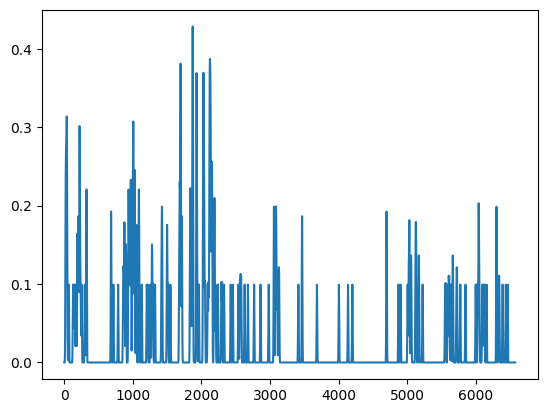

In [18]:
spikes = val_dataset.get_recording_data("perich_miller_population_2018/m_20150511_center_out_reaching").slice(3421.008000,3486.730033, reset_origin=False).smoothed_spikes.smoothed_spikes
plt.plot(spikes[:,0])

In [2]:
import matplotlib.pyplot as plt

recording = val_dataset.get_recording_data("perich_miller_population_2018/m_20150511_center_out_reaching")

sliced_recording = recording.slice(3421.008000,3486.730033, reset_origin=False)
pos = sliced_recording.vel_regular.data
plt.plot(pos[:,0], pos[:,1])

NameError: name 'val_dataset' is not defined

In [28]:
val_loader = DataLoader(val_dataset, batch_size=512, sampler=val_sampler, collate_fn=pad_collate, num_workers=8)

In [ ]:
for batch in tqdm(val_loader):
    pass

  4%|▎         | 2/57 [00:12<05:34,  6.09s/it]/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
 32%|███▏      | 18/57 [01:41<03:54,  6.02s/it]/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
 35%|███▌      | 20/57 [02:09<06:01,  9.76s/it]/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
100%|██████████| 57/57 [30:42<00:00, 32.32s/it]


In [1]:
import jax.numpy as jnp
mask1 = jnp.ones((16,101)) 
mask2 = jnp.zeros((16,100))
flattened_mask1 = jnp.reshape(mask1, shape=(-1)) 
flattened_mask1 = flattened_mask1[..., None]
flattened_mask2 = jnp.reshape(mask2, shape=(-1))
flattened_mask2 = flattened_mask2[..., None]

x1 = jnp.zeros((16,101,625))
x1 = jnp.reshape(x1, shape=(-1, x1.shape[-1]))
x1 = jnp.where(flattened_mask1, x1, 0)
x2 = jnp.zeros((16,100,625))
x2 = jnp.reshape(x2, shape=(-1, x2.shape[-1]))
x2 = jnp.where(flattened_mask2, x2, 0)
x = jnp.concatenate([x1, x2], axis=0)


dataset_group_idxs1 = jnp.zeros((16))
dataset_group_idxs2 = jnp.ones((16))
idxs1_expanded = jnp.repeat(dataset_group_idxs1[:, None], x1.shape[1], axis=1)
idxs2_expanded = jnp.repeat(dataset_group_idxs2[:, None], x2.shape[1], axis=1)

idxs1_expanded = jnp.reshape(idxs1_expanded, shape=(-1))
idxs1_expanded = jnp.where(flattened_mask1, idxs1_expanded, 0)
idxs2_expanded = jnp.reshape(idxs2_expanded, shape=(-1))
idxs2_expanded = jnp.where(flattened_mask2, idxs2_expanded, 0)
idxs_expanded = jnp.concatenate([idxs1_expanded, idxs2_expanded], axis=0)




#print all dims
print(x.shape)
print(idxs_expanded.shape)
print(flattened_mask1.shape)
print(flattened_mask2.shape)


(3216, 625)
(3216, 10000)
(1616, 1)
(1600, 1)


In [2]:
idxs2_expanded

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [3]:
dataset_group_idxs_expanded = jnp.repeat(dataset_group_idxs[:, None], x0.shape[1], axis=1)
dataset_group_idxs_expanded.shape

(1024, 1001)

In [ ]:
jnp.where( jnp.reshape(dataset_group_idxs_expanded, shape=(-1)).shape, )

(1025024,)

In [1]:
import torch

def pad_collate(batch, fixed_seq_len=None):
    # Assume batch is a list of dicts with keys: 'neural_input', 'behavior_input', etc.
    # Each 'neural_input' is a tensor of shape (timesteps, units)
    neural_inputs = [item['neural_input'].squeeze(0) for item in batch]  # (timesteps, units)
    behavioral_inputs = [item['behavior_input'].squeeze(0) for item in batch]
    
    # Determine the fixed sequence length
    if fixed_seq_len is None:
        max_len = max(x.shape[0] for x in neural_inputs)
    else:
        max_len = fixed_seq_len

    # Pad or truncate each sequence to fixed length
    def pad_or_truncate(tensor, max_len):
        seq_len = tensor.shape[0]
        if seq_len == max_len:
            return tensor
        elif seq_len > max_len:
            return tensor[:max_len]
        else:
            pad_shape = (max_len - seq_len,) + tensor.shape[1:]
            pad_tensor = torch.zeros(pad_shape, dtype=tensor.dtype, device=tensor.device)
            return torch.cat([tensor, pad_tensor], dim=0)

    padded_neural = torch.stack([pad_or_truncate(x, max_len) for x in neural_inputs])  # (batch, max_len, units)
    padded_behavior = torch.stack([pad_or_truncate(x, max_len) for x in behavioral_inputs])

    # Create mask: 1 for real data, 0 for padding
    lengths = [x.shape[0] for x in neural_inputs]
    mask = torch.zeros((len(batch), max_len), dtype=torch.bool)
    for i, l in enumerate(lengths):
        mask[i, :min(l, max_len)] = 1

    # Stack other fields (e.g., dataset_group_idx)
    dataset_group_idx = torch.stack([item['dataset_group_idx'] for item in batch])
    
    return {
        'neural_input': padded_neural,
        'behavior_input': padded_behavior,
        'mask': mask,
        'dataset_group_idx': dataset_group_idx,
        # add other fields as needed
    }

In [4]:
import torch

batched = pad_collate([
    {"neural_input": torch.zeros((1, 1001, 625)), "behavior_input": torch.zeros((1, 1001, 2)), "dataset_group_idx": torch.zeros((1))},
    {"neural_input": torch.zeros((1, 1000, 625)), "behavior_input": torch.zeros((1, 1000, 2)), "dataset_group_idx": torch.ones((1))},
],1000)

In [5]:
batched["neural_input"].shape

torch.Size([2, 1000, 625])